In [1]:
# drop_rate = 0.4
# warmup

In [2]:
import datetime
import gc
import glob
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import multiprocessing
import os
import pickle
import random
import time

from fastprogress import master_bar, progress_bar
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordTokenizer
import numpy as np
import pandas as pd

import seaborn as sns
import shap
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset


%matplotlib inline
sns.set(style='ticks')
tqdm.pandas()

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
# https://github.com/ildoonet/pytorch-gradual-warmup-lr/blob/master/warmup_scheduler/scheduler.py

from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau


class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier <= 1.:
            raise ValueError('multiplier should be greater than 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super().__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

In [4]:
def get_logger():
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    # handler1
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(asctime)s %(levelname)8s %(message)s"))
    # handler2
    handler2 = FileHandler(filename=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".log")
    handler2.setFormatter(Formatter("%(asctime)s %(levelname)8s %(message)s"))
    # addHandler
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_loss(y_true, y_pred, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1-epsilon)
    return -(np.log(y_pred) * y_true + np.log(1 - y_pred) * (1 - y_true))

class JigsawEvaluator:
    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score, bias_metrics[0], bias_metrics[1], bias_metrics[2]

In [5]:
# logger
logger = get_logger()

# parameters
n_workers = 4
n_splits = 5
seed = 777
seed_everything(seed)

maxlen = 300
max_features = 410047

batch_size = 512
lr = 0.001
epochs = 10
n_fold = 4
drop_rate = 0.4 # default=0.3

# path
CRAWL_EMBEDDING_PATH = '../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl'
GLOVE_EMBEDDING_PATH = '../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl'
# GOOGLE_EMBEDDING_PATH = '../input/quoratextemb/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
# WIKI_EMBEDDING_PATH = '../input/quoratextemb/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

# constants
target = 'target'
aux_target = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]

### loading

In [6]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (1804874, 45)
test shape: (97320, 2)


In [7]:
FOLD_PATH = "../input/toxic-folds/fold01.csv"
fold = pd.read_csv(FOLD_PATH)
train["fold_id"] = fold["fold_id"].values
del fold; gc.collect()

486

In [8]:
FOLD_PATH_JIGSAW = "../input/jigsaw-old-folds/folds_oldcompe.csv"
OLD_PATH = "../input/jigsaw-toxic-comment-classification-challenge/train.csv"

old_folds = pd.read_csv(FOLD_PATH_JIGSAW)
old_df = pd.read_csv(OLD_PATH)
old_df["target"] = old_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1)
old_df["target"] = (old_df["target"] >= 1).astype("int8")
old_df["fold_id"] = old_folds.fold_id
old_df = old_df[old_folds.fold_id != n_fold]
old_y = np.where(old_df['target'] >= 0.5, 1, 0)
del old_folds
gc.collect()

21

In [9]:
# text symbols
symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
small_caps_mapping = { 
"ᴀ": "a", "ʙ": "b", "ᴄ": "c", "ᴅ": "d", "ᴇ": "e", "ғ": "f", "ɢ": "g", "ʜ": "h", "ɪ": "i", 
"ᴊ": "j", "ᴋ": "k", "ʟ": "l", "ᴍ": "m", "ɴ": "n", "ᴏ": "o", "ᴘ": "p", "ǫ": "q", "ʀ": "r", 
"s": "s", "ᴛ": "t", "ᴜ": "u", "ᴠ": "v", "ᴡ": "w", "x": "x", "ʏ": "y", "ᴢ": "z"
}
contraction_mapping = {
"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
"didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
"he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
"I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": 
"i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
"mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
"mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
"o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
"sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
"she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
"shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's":"this is","that'd": "that would", 
"that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
"here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
"they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
"we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
"what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
"won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
"y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
"you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
"trump's": "trump is", "obama's": "obama is", "canada's": "canada is", "today's": "today is"
}
specail_signs = { "…": "...", "₂": "2"}
specials = ["’", "‘", "´", "`"]

In [10]:
treebank_tokenizer = TreebankWordTokenizer()

isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}

def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

def handle_contractions(x):
    x = treebank_tokenizer.tokenize(x)
    return x

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def clean_text(x):
    x = handle_punctuation(x)
    x = handle_contractions(x)
    x = fix_quote(x)
    return x

def apply_clean_text(X):
    if not isinstance(X, pd.Series):
        X = pd.Series(X)
    return X.apply(clean_text)
    
def parallel_clean_text(X):
    with multiprocessing.Pool(processes=n_workers) as p:
        splits = np.array_split(X, n_workers)
        pool_results = p.map(apply_clean_text, splits)
    return np.concatenate(pool_results)


In [11]:
X_old = parallel_clean_text(old_df['comment_text'])
del treebank_tokenizer, old_df['comment_text']; gc.collect()

14

In [12]:
tokenizer = pd.read_pickle('../input/toxicpreprocesseddata/tokenizer.pkl')
X_old = tokenizer.texts_to_sequences(X_old)
old_lengths = np.array([len(x) for x in X_old])
X_old = sequence.pad_sequences(X_old, maxlen=maxlen)
print("len(X_old): ", len(X_old))
del tokenizer; gc.collect()

len(X_old):  127657


0

In [13]:
X_train = pd.read_pickle('../input/toxicpreprocesseddata/X_train.pkl')
X_test = pd.read_pickle('../input/toxicpreprocesseddata/X_test.pkl')
embedding_matrix = pd.read_pickle('../input/toxicpreprocesseddata/embedding_matrix.pkl')
tokenizer = pd.read_pickle('../input/toxicpreprocesseddata/tokenizer.pkl')
train_lengths = pd.read_pickle('../input/toxicpreprocesseddata/train_lengths.pkl')
test_lengths = pd.read_pickle('../input/toxicpreprocesseddata/test_lengths.pkl')

In [14]:
X_train.shape

(1804874, 300)

In [15]:
train.shape

(1804874, 46)

In [16]:
# concat処理
X_train = np.append(X_train, X_old, axis=0)
print("created X_train")
train = train.append(old_df).reset_index(drop=True)
print("created train")
train_lengths = np.append(train_lengths, old_lengths)
del X_old, old_df, old_lengths; gc.collect()

train_index = train[train.fold_id!=n_fold].index
valid_index = train[train.fold_id==n_fold].index
print("created train_index, valid_index")

created X_train


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


created train
created train_index, valid_index


In [17]:
len(valid_index)

360974

In [18]:
valid_index = [i for i in valid_index if i<1804874]
print("len(fixed valid_index(only original train data)): ", len(valid_index))
gc.collect()

len(fixed valid_index(only original train data)):  360974


0

In [19]:
len(valid_index)

360974

In [20]:
# Overall
weights = np.ones((len(train),)) / 4

# Subgroup
weights += (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4

# Background Positive, Subgroup Negative
weights += (((train[target].values>=0.5).astype(bool).astype(np.int) +
   (1-(train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int)) ) > 1).astype(bool).astype(np.int) / 4

# Background Negative, Subgroup Positive
weights += (((train[target].values<0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1).astype(bool).astype(np.int) / 4

#loss_weight = 1.0 / weights.mean()
loss_weight = 0.5
print(loss_weight)

y_train = np.vstack([train[target], weights]).T
# y_train = np.vstack([np.where(train[target]>=0.5, train[target], 0), weights]).T
y_aux_train = train[[target]+aux_target]
y_train = np.hstack([y_train, y_aux_train])
print(f'y shape: {y_train.shape}')

0.5
y shape: (1932531, 8)


### dataloader

In [21]:
class SequenceBucketCollator():
    def __init__(self, choose_length, sequence_index, length_index, label_index=None):
        self.choose_length = choose_length
        self.sequence_index = sequence_index
        self.length_index = length_index
        self.label_index = label_index
        
    def __call__(self, batch):
        batch = [torch.stack(x) for x in list(zip(*batch))]
        
        sequences = batch[self.sequence_index]
        lengths = batch[self.length_index]
        
        length = self.choose_length(lengths)
        mask = torch.arange(start=maxlen, end=0, step=-1) < length
        padded_sequences = sequences[:, mask]
        
        batch[self.sequence_index] = padded_sequences
        
        if self.label_index is not None:
            return [x for i, x in enumerate(batch) if i != self.label_index], batch[self.label_index]
    
        return batch
    
def prepare_data_loader(X, lengths, y=None, shuffle=False):
    if y is None:
        dataset = TensorDataset(torch.from_numpy(X), 
                                torch.from_numpy(lengths))
        collator = SequenceBucketCollator(lambda lenghts: lenghts.max(), 
                                          sequence_index=0, 
                                          length_index=1)
    else:
        dataset = TensorDataset(torch.from_numpy(X), 
                                torch.from_numpy(lengths), 
                                torch.tensor(y, dtype=torch.float32))
        collator = SequenceBucketCollator(lambda lenghts: lenghts.max(), 
                                          sequence_index=0, 
                                          length_index=1, 
                                          label_index=2)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collator)

### model

In [22]:
def custom_loss(data, targets):
    ''' Define custom loss function for weighted BCE on 'target' column '''
    bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:, 1:2])(data[:, :1], targets[:, :1])
    bce_loss_2 = nn.BCEWithLogitsLoss()(data[:, 1:], targets[:, 2:])
    return (bce_loss_1 * loss_weight) + bce_loss_2

#def custom_loss(data, targets):
#    ''' Define custom loss function for weighted BCE on 'target' column '''
#    bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:, 1:2])(data[:, :1], targets[:, :1])
#    return bce_loss_1

In [23]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class EmbLSTM(nn.Module):
    def __init__(self, embedding_matrix, max_features, num_aux_targets=6):
        super().__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(drop_rate)
        
        self.lstm1 = nn.LSTM(embed_size, 128, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(128 * 2, 128, bidirectional=True, batch_first=True)
        #self.lstm2 = nn.GRU(128 * 2, 128, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(512, 512)
        self.linear2 = nn.Linear(512, 512)
        #self.linear1 = nn.Sequential(
        #    nn.BatchNorm1d(512),
        #    nn.Linear(512, 512),
        #    #nn.PReLU(),
        #    nn.ReLU(inplace=True),
        #)
        #self.linear2 = nn.Sequential(
        #    nn.BatchNorm1d(512),
        #    nn.Linear(512, 512),
        #    #nn.PReLU(),
        #    nn.ReLU(inplace=True),
        #)
        
        self.linear_out = nn.Linear(512, 1)
        self.linear_aux_out = nn.Linear(512, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        
        out = torch.cat([result, aux_result], 1)
        
        return out
    
class EmbLSTMGRUCNN(nn.Module):
    def __init__(self, embedding_matrix, max_features, num_aux_targets=6):
        super().__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(drop_rate)
        
        self.lstm1 = nn.LSTM(embed_size, 80, bidirectional=True, batch_first=True)
        self.lstm2 = nn.GRU(80*2, 80, bidirectional=True, batch_first=True)
        self.cnn = nn.Conv1d(80*2, 64, kernel_size=3, padding=0)
    
        self.linear1 = nn.Sequential(
            nn.BatchNorm1d(458),
            nn.Linear(458, 458),
            nn.ReLU(inplace=True)
        )
        self.linear2 = nn.Sequential(
            nn.BatchNorm1d(458),
            nn.Linear(458, 458),
            nn.ReLU(inplace=True)
        )

        self.linear_out = nn.Linear(458, 1)
        self.linear_aux_out = nn.Linear(458, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        x = self.cnn(h_lstm2.permute(0, 2, 1))
        
        # global average pooling
        avg_pool = torch.mean(x, 1)
        # global max pooling
        max_pool, _ = torch.max(x, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = self.linear1(h_conc)
        h_conc_linear2  = self.linear2(h_conc)
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

### training

In [24]:
def save_checkpoint(filepath, model, optimizer, epoch):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, filepath)

def plot_losses(train_losses, valid_losses, fold=0):
    plt.clf()
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend()
    plt.title(f'loss history of fold {fold}')
    plt.savefig(f'loss_history_of_fold_{fold}.png')
    plt.show()
    
def plot_histogram(y_true, y_pred, n_bins=50, fold=0):
    bins = np.linspace(0, 1, n_bins)
    plt.clf()
    plt.hist(y_pred[:, 0], bins=bins, label='pred')
    plt.hist(y_true[:, 0], bins=bins, label='true')
    plt.legend()
    plt.title(f'validation histogram of fold {fold}')
    plt.savefig(f'validation_histogram_of_fold_{fold}.png')
    plt.show()
    
def plot_aucs(aucs, auc_type, fold=0):
    total = sum(np.power(aucs, -5))
    score = np.power(total / len(aucs), 1 / -5)
    
    plt.clf()
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(identity_columns, aucs)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x()+p.get_width()/2, int(p.get_height()*0.95)),
                    ha='center', va='center', fontsize=20, color='blue', xytext=(0, 20), 
                    textcoords='offset points')
    plt.xticks(rotation=10)
    plt.title(f'{auc_type} {score} barplot of fold {fold}')
    plt.savefig(f'{auc_type}_{score}_barplot_of_fold_{fold}.png')
    plt.show()

In [25]:
def inference(model, X):
    logits = model(X)
    probabilities = torch.sigmoid(logits)
    return logits, probabilities
        
def evaluate_single_epoch(model, dataloader, criterion, epoch, evaluator, return_pred=False):
    model.eval()
    with torch.no_grad():
        valid_preds = []
        loss_list = []
        for i, (X, y) in enumerate(dataloader):
            X = X[0].cuda().long() # X[0]: text sequences, X[1]: lengths
            y = y.cuda().float()
            logits, probabilities = inference(model, X)
            
            loss = criterion(logits, y)
            loss_list.append(loss.item())
            valid_preds.append(probabilities.cpu().numpy())

        valid_preds = np.concatenate(valid_preds)

        log_dict = {}
        score, subgroup_auc, bpsn_auc, bnsp_auc = evaluator.get_final_metric(valid_preds[:, 0])
        log_dict['score'] = score
        log_dict['subgroup_auc'] = subgroup_auc
        log_dict['bpsn_auc'] = bpsn_auc
        log_dict['bnsp_auc'] = bnsp_auc
        log_dict['loss'] = np.mean(loss_list)
        
        if return_pred:
            log_dict['pred'] = valid_preds
            
    return log_dict

def train_single_epoch(model, dataloader, criterion, optimizer, epoch, parent_bar, scheduler=None):
    model.train()
    log_dict = {}
    log_dict['loss'] = 0
    for X, y in progress_bar(dataloader, parent=parent_bar):
        X = X[0].cuda().long() # X[0]: text sequences, X[1]: lengths
        y = y.cuda().float()
        logits, probabilities = inference(model, X)
        
        loss = criterion(logits, y)
        log_dict['loss'] += loss.item() / len(dataloader)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        log_dict['lr'] = optimizer.param_groups[0]['lr']
        
    if scheduler is not None:
        scheduler.step()
        
    return log_dict

def predict_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        test_preds = []
        for i, X in enumerate(dataloader):
            X = X[0].cuda().long() # X[0]: text sequences, X[1]: lengths
            logits, probabilities = inference(model, X)
            test_preds.append(probabilities.cpu().numpy())
    test_preds = np.concatenate(test_preds)
    return test_preds

In [26]:
# kfold = train.copy()
# kfold['fold_id'] = 0

# cv = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
# for fold, (train_index, valid_index) in enumerate(cv.split(range(len(train)), np.where(train[target]>0.5, 1, 0))):
#     kfold.loc[valid_index, 'fold_id'] = fold
# kfold[['fold_id']].to_csv('fold01.csv', index=False)

# del kfold; gc.collect()

In [27]:
cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
# for fold, (train_index, valid_index) in enumerate(cv.split(range(len(train)), np.where(train[target]>0.5, 1, 0))):
#     if fold==n_fold:
        
fold = n_fold

# data split
y_train[np.isnan(y_train)] = 0
X_trn, X_val = X_train[train_index], X_train[valid_index]
y_trn, y_val = y_train[train_index], y_train[valid_index]

trn_lengths, val_lengths = train_lengths[train_index], train_lengths[valid_index]
train = train.fillna(0)
y_val_target = train.loc[valid_index, target].values
y_val_identity = train.loc[valid_index, identity_columns].values

In [28]:
train_loader = prepare_data_loader(X_trn, trn_lengths, y=y_trn, shuffle=True)
valid_loader = prepare_data_loader(X_val, val_lengths, y=y_val, shuffle=False)
evaluator = JigsawEvaluator(y_val_target, y_val_identity)

# model
model = EmbLSTM(embedding_matrix, max_features).cuda()
#model = EmbLSTMGRUCNN(embedding_matrix, max_features).cuda()
criterion = custom_loss
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, amsgrad=False)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=4, eta_min=1e-3)
scheduler = GradualWarmupScheduler(optimizer, multiplier=1.2, total_epoch=2, after_scheduler=scheduler_cosine)
#     scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)
#     scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)

# main loop
best_epoch = -1
best_score = 0.

train_losses, valid_losses = [], []

mb = master_bar(range(epochs))
for epoch in mb:
    scheduler.step() # 2 epoch warmup, after that schedule as scheduler_cosine
    logger.info(f'Epoch {epoch+1} - optimizer: {optimizer.state_dict()["param_groups"]} - scheduler: {scheduler.state_dict()}')
    log_dict_train = train_single_epoch(model, train_loader, criterion, optimizer, epoch, mb) # loss, lr
    log_dict_valid = evaluate_single_epoch(model, valid_loader, criterion, epoch, evaluator) # loss, score
    train_losses.append(log_dict_train['loss'])
    valid_losses.append(log_dict_valid['loss'])

    if (epoch + 1) % 1 == 0:
        mb.write(f'Epoch {epoch+1} - avg_train_loss: {log_dict_train["loss"]:.4f}  avg_val_loss: {log_dict_valid["loss"]:.4f}  val_score: {log_dict_valid["score"]:.6f}')
        logger.info(f'Epoch {epoch+1} - avg_train_loss: {log_dict_train["loss"]:.4f} avg_val_loss: {log_dict_valid["loss"]:.4f}  val_score: {log_dict_valid["score"]:.6f}')

    if log_dict_valid["score"] > best_score:
        best_epoch = epoch + 1
        best_score = log_dict_valid["score"]
        save_checkpoint(f'weight_best_fold_{fold}.pth', model, optimizer, epoch)
        if epoch - best_epoch > 3:
            break

# load best
state = torch.load(f'weight_best_fold_{fold}.pth')
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

# save valid
log_dict = evaluate_single_epoch(model, valid_loader, criterion, 0, evaluator, return_pred=True)
pred_valid = log_dict['pred']
np.save(f'pred_valid_fold_{fold}.npy', pred_valid)

# evaluate
score, subgroup_auc, bpsn_auc, bnsp_auc = evaluator.get_final_metric(pred_valid[:, 0])
subgroup_auc = evaluator._power_mean(subgroup_auc)
bpsn_auc = evaluator._power_mean(bpsn_auc)
bnsp_auc = evaluator._power_mean(bnsp_auc)
overall_auc = evaluator._calculate_overall_auc(pred_valid[:, 0])
logger.info(f'metric: {score:.6f}, overall auc: {overall_auc:.6f}, subgroup_auc: {subgroup_auc:.6f}, bpsn_auc: {bpsn_auc:.6f}, bnsp_auc: {bnsp_auc:.6f}')

# plot
plot_losses(train_losses, valid_losses, fold=fold)
plot_histogram(y_val, pred_valid, n_bins=50, fold=fold)
plot_aucs(log_dict['subgroup_auc'], 'subgroup_auc', fold=fold)
plot_aucs(log_dict['bpsn_auc'], 'bpsn_auc', fold=fold)
plot_aucs(log_dict['bnsp_auc'], 'bnsp_auc', fold=fold)

del model; gc.collect(); torch.cuda.empty_cache()


2019-06-22 10:22:29,723     INFO Epoch 1 - optimizer: [{'lr': 0.0011, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'initial_lr': 0.001, 'params': [140040770468384, 140040770933024, 140040770469680, 140040770467664, 140040770468888, 140040770469608, 140040770469824, 140040770467376, 140040770466224, 140040770466728, 140040770467160, 140040770465936, 140040770466512, 140040770466008, 140040770925912, 140040770925120, 140040770926704, 140040770929792, 140040770931736, 140040770931304, 140040770930224, 140040770930152, 140040770930080, 140040770930872, 140040770931952]}] - scheduler: {'multiplier': 1.2, 'total_epoch': 2, 'after_scheduler': <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7f5d964baa20>, 'finished': False, 'base_lrs': [0.001], 'last_epoch': 1}
2019-06-22 10:34:08,755     INFO Epoch 1 - avg_train_loss: 0.1444 avg_val_loss: 0.1455  val_score: 0.928394
2019-06-22 10:34:13,479     INFO Epoch 2 - optimizer: [{'lr': 0.0012, 'betas': (0.9, 0.999)

### visualize

In [29]:
pd.set_option('display.max_colwidth', -1)

In [30]:
#cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
# for fold, (train_index, valid_index) in enumerate(cv.split(range(len(train)), np.where(train[target]>0.5, 1, 0))):
#     if fold==n_fold:
valid = train.loc[valid_index]
valid['pred'] = np.load(f'pred_valid_fold_{fold}.npy')[:, 0]
valid['logloss'] = log_loss(valid[target].values, valid['pred'].values)

valid.sort_values('logloss', ascending=False).loc[:, ['id', 'comment_text', 'target', 'pred', 'logloss']].head(30)

,id,comment_text,target,pred,logloss
190446,474051,"are they surprised? surprised? read what little local history exists - you should be able to map out the ""routes"" of the old trollies.",1.000000,0.011919,4.429653
860284,5172977,Between Dalton McGuinty and Kathleen Wynne\nthey doubled the provincial debt to over $300 Billion\nand she has the nerve to even think of\nBasic income\n.\nshame\nunethical\nimmoral\nsinful\ninsane\nincompetent,1.000000,0.013695,4.290715
9110,253508,I.d.i.o.t.s all.,0.900000,0.009332,4.207807
1664253,6162037,what rubbish\n\nwhy not examine the role of media as the crucial explanatory variable\n\neverything kids learn outside of school is influenced by it,1.000000,0.015990,4.135787
1492735,5947182,"Alceste, I'm assuming you take a size medium pussyh at?",0.900000,0.010785,4.077752
76512,336206,I misspelled expect in my prior comment,0.700000,0.003172,4.028418
1240658,5630606,Who gives a flying freak about what Kim and Park are making or not making? Really? This is what the SA chooses to write editorials about?,1.000000,0.020962,3.865027
960637,5293418,"yes, stupiditing",0.900000,0.014993,3.781680
973847,5309299,try again loser\nhttps://www.youtube.com/watch?v=SXxHfb66ZgM\nhttps://www.youtube.com/watch?v=Zm7_FVS3IMo\nhttps://www.youtube.com/watch?v=veLJSKXZJbw,0.700000,0.004633,3.763548
153190,429494,"Do provide evidence of all these claims. It appears that you are just repeating the talking heads rhetoric and that you do not have the capability of thinking on your own, especially critically",1.000000,0.024355,3.715011


### predict

In [31]:
def submission(y_pred):
    sub = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')
    sub['prediction'] = y_pred[:, 0]
    sub.to_csv('submission.csv', index=False)
    return sub

In [32]:
test_loader = prepare_data_loader(X_test, test_lengths, shuffle=False)

pred_tests = []
weights = sorted(glob.glob('weight_best_fold_*.pth'))
for fold, path in enumerate(weights):
    model = EmbLSTM(embedding_matrix, max_features).cuda()
    state = torch.load(path)
    model.load_state_dict(state['state_dict'])
    
    pred_test = predict_model(model, test_loader)
    np.save(f'pred_test_fold_{fold}.npy', pred_test)
    pred_tests.append(pred_test)
    
    del model; gc.collect(); torch.cuda.empty_cache()
    
pred_tests = np.mean(pred_tests, axis=0)

In [33]:
sub = submission(pred_tests)
sub.head()

,id,prediction
0,7000000,0.047286
1,7000001,0.005536
2,7000002,0.073810
3,7000003,0.034756
4,7000004,0.701859


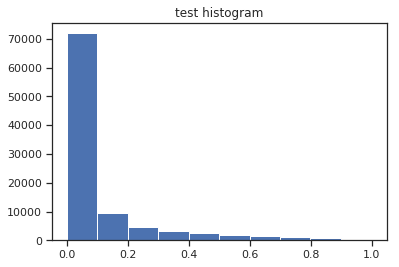

In [34]:
plt.clf()
plt.hist(pred_tests[:, 0])
plt.title('test histogram')
plt.show()